Estimate parameters for resampling procedure (trial generation).

* Number of resampling iterations: M is based on bootstrapping stability analysis 
* Number of trials per resampling: N = 40 (based on data in monkey dataset so the number of trials is from experiments)

#### Bootstrapping Stability Analysis (for M)

We determine a reasonable M by checking when the mean stabilizes:

1. Compute the cumulative mean of intrinsic timescales as M increases.
2. Plot the standard error (SE) of the mean vs. M.
3. Pick M where SE flattens out.

Start with M = 20 ([20,30,40,50,100])

#### Selecting number of signals for M estimate

Spike trains are coming from different brain areas and may have different variance so using only one is not gut. The total number of signals and the min per area number of signals are set. After sampling the min number per area the rest is sampled proportionally to the number of signals in the area.

In [1]:
import csv
import sys
import pickle
import numpy as np
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
#os.chdir(os.path.abspath("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_tau import fit_single_exp, func_single_exp_monkey
from cfg_global import project_folder_path
from calculate_acf import acf_pearsonr_trial_avg, acf_sttc_trial_avg, acf_sttc_trial_concat
from spike_train_utils import bin_spike_train_fixed_len, get_trials, bin_trials
os.chdir(current_wd)

In [2]:
dataset_folder = project_folder_path + 'results\\allen_mice\\dataset\\cut_30min\\'
fig_folder = project_folder_path + 'results\\allen_mice\\fig_draft_paper\\'

In [17]:
estimate_m = False
save_fig = True

### Get data

In [3]:
if estimate_m:
    csv_data_file = dataset_folder + 'sua_list_constrained.csv'
    with open(csv_data_file, newline='') as f:
        reader = csv.reader(f)
        sua_list = list(reader)
    print(f'Loaded N units {len(sua_list)}')

Loaded N units 5775


In [4]:
units_info_df = pd.read_pickle(dataset_folder + 'sua_list_constrained_units_df.pkl')

### Estimate M

#### Run bootstrapping

In [5]:
def sample_signals(units_df, min_per_area, n_total):
    sampled_units = []

    area_counts = units_df["ecephys_structure_acronym"].value_counts()
    base_samples = {area: min(min_per_area, count) for area, count in area_counts.items()}
    remaining_samples = n_total - sum(base_samples.values())
    total_remaining = sum(area_counts) - sum(base_samples.values())
    print(f'total {n_total}, min per area {min_per_area}. Base samples {base_samples}, \nproportional samples {remaining_samples}')
    
    # get min_per_area, then sample proportionally
    for area, count in area_counts.items():
        base_samples = min(min_per_area, count)
        extra_samples = int((count / total_remaining) * remaining_samples) if total_remaining > 0 else 0
        n_samples = base_samples + extra_samples
        sampled_units.extend(units_info_df[units_info_df["ecephys_structure_acronym"] == area]
                             .sample(n=min(n_samples, count), random_state=42)["unit_id"].tolist())
    
    return sampled_units

In [8]:
if estimate_m:
    fs = 30000
    signal_len = int(30 * 60 * fs)
    n_lags = 20
    bin_size = 50 # in ms
    trial_len = int(n_lags * bin_size * (fs/1000))
    
    n_trials = 40 # this is fixed based on experimental datasets
    m_iterations = [20, 40, 60, 80, 100, 150, 200, 500, 1000]
    
    n_total_signals = 100
    min_signal_per_area = 10

In [9]:
if estimate_m:
    units_to_sample = sample_signals(units_info_df, min_signal_per_area, n_total_signals)
    random_signals = [item for item in sua_list if item[2] in units_to_sample]
    
    output_log = dataset_folder + f'resampling//resampling_params_estimate_{n_signals}_signals.txt'
    old_stdout = sys.stdout
    sys.stdout = open(output_log, 'w')
    
    signal_tau_dict = {}
    
    for signal_idx, signal in enumerate(random_signals):
        print(f'###\nCalculating for {signal_idx} signal')
        spikes = np.asarray([int(spike) for spike in signal[8:]])
    
        tau_dict = {}
        for m_iteration in m_iterations:
            print(f'calculating for {m_iteration} resampling iterations')
            tau_l = []
            for m in range(m_iteration):
                spikes_trials = get_trials(spikes, signal_len, n_trials, trial_len, verbose_=False)
                spikes_trials_binned = bin_trials(spikes_trials, trial_len, int(bin_size*(fs/1000)))
                # get taus
                _, acf_average = acf_pearsonr_trial_avg(spikes_trials_binned, n_lags, verbose_=False)
                _, _, tau, _, _, _, _ = fit_single_exp(acf_average, start_idx_=1, exp_fun_=func_single_exp_monkey)
                tau_l.append(tau)
            tau_dict[m_iteration] = tau_l
            
        signal_tau_dict[signal[2]] = tau_dict
    
    with open(dataset_folder + f'resampling//signal_tau_dict_{n_signals}_signals.pkl', "wb") as f:
        pickle.dump(signal_tau_dict, f)
    
    sys.stdout = old_stdout

#### Find M

In [10]:
with open(dataset_folder + f'resampling//signal_tau_dict_20_signals.pkl', "rb") as f:
    signal_tau_dict = pickle.load(f)
signal_tau_dict.keys()

dict_keys(['950938932', '950928487', '950924978', '950999410', '951013444', '951070584', '951085015', '951142465', '951146027', '951137420', '951136509', '951141109', '951086045', '951101562', '951140992', '951188341'])

In [11]:
# Lists to store values for tau_df
signal_l = []
m_iterations_l = []
tau_nanmean_l = []
sem_tau_l = []

# Process signal_tau_dict into tau_df
for k, v in signal_tau_dict.items():
    for kk, vv in v.items():
        vv_ = [tau_ for tau_ in vv if tau_ < 100]  # Filtering extreme values
        tau = np.nanmean(vv_)
        tau_sem = stats.sem(vv_, nan_policy='omit')  # Handle NaNs properly
        signal_l.append(k)
        m_iterations_l.append(kk)
        tau_nanmean_l.append(tau)
        sem_tau_l.append(tau_sem)

# Create tau_df
tau_df = pd.DataFrame({
    "signal": signal_l,
    "m_iterations": m_iterations_l,
    "tau_nanmean": tau_nanmean_l,
    'tau_sem': sem_tau_l
})
tau_df['tau_sem_ms'] = tau_df['tau_sem'] * 50

# Check the stabilization of SE
threshold = 25 # ms
stabilization_list = []

for signal in tau_df["signal"].unique():
    signal_data = tau_df.query('signal == @signal').sort_values(by='m_iterations')
    sem_tau_values = signal_data['tau_sem_ms'].values
    m_iterations_values = signal_data['m_iterations'].values
    
    stabilization_point = np.nan  # Default to NaN if no stabilization is found
    for i in range(1, len(sem_tau_values)):
        if sem_tau_values[i] <= threshold:
            stabilization_point = m_iterations_values[i]
            break
    stabilization_list.append({"signal": signal, "stabilization_point": stabilization_point})

# Create stabilization_df
stabilization_df = pd.DataFrame(stabilization_list)

C:\Users\ipochino\AppData\Local\Temp\ipykernel_3792\4243153100.py:6: UserWarning: 
The palette list has fewer values (1) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(ax=axes[0], data=tau_df, x="m_iterations", hue='signal', y="tau_sem_ms", palette=['slategray'], lw=0.5, legend=False)


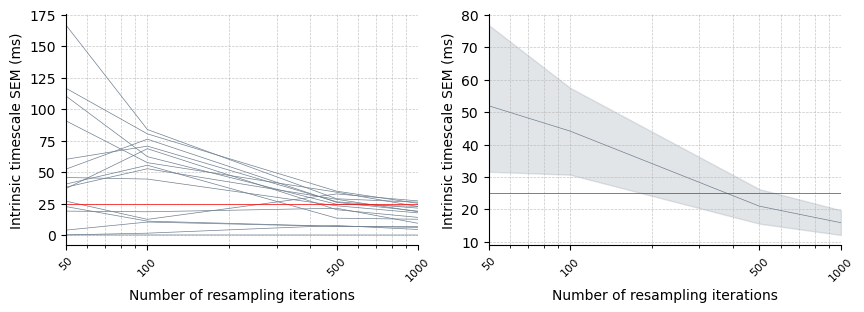

In [18]:
# m_iterations_x_axes = [20, 40, 60, 80, 100, 150, 200, 500, 1000]
# 2nd plot 95% CI
m_iterations_x_axes = [50, 100, 500, 1000]

fig, axes = plt.subplots(1,2,figsize=(10,3))

sns.lineplot(ax=axes[0], data=tau_df, x="m_iterations", hue='signal', y="tau_sem_ms", palette=['slategray'], lw=0.5, legend=False)

sns.lineplot(ax=axes[1], data=tau_df, x="m_iterations", y="tau_sem_ms", color='slategray', lw=0.5, legend=False)

for ax in axes.flat:
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_xscale('log')
    ax.set_xticks(m_iterations_x_axes)
    ax.set_xticklabels(m_iterations_x_axes, rotation=45, fontsize=8)
    ax.set_xlim([50, 1000])
    ax.set_xlabel('Number of resampling iterations')
    ax.set_ylabel('Intrinsic timescale SEM (ms)')
    ax.axhline(y=25, lw=0.5, color='red')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'n_iterations_vs_sem.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'n_iterations_vs_sem.svg' , bbox_inches='tight')

In [13]:
n_signals = len(stabilization_df)
n_signals_below_l = []
for n_iterations in m_iterations_x_axes:
    n_signals_below = len(stabilization_df.query('stabilization_point <= @n_iterations'))
    n_signals_below_l.append(n_signals_below/n_signals * 100)

stab_below_df = pd.DataFrame({
    "m_iterations": m_iterations_x_axes,
    "n_signals_below_perc": n_signals_below_l
})

In [14]:
stab_point_count_df = stabilization_df.groupby(by='stabilization_point', dropna=False, as_index=False).count()
stab_point_count_df['stabilization_point'] = stab_point_count_df['stabilization_point'].fillna('no')
stab_point_count_df['stabilization_point'] = pd.Categorical(stab_point_count_df['stabilization_point'], 
                                                            categories=['no', 50, 100, 500, 1000], ordered=True)
stab_point_count_df_sorted = stab_point_count_df.sort_values(by='stabilization_point')
stab_point_count_df_sorted

,stabilization_point,signal
3,no,2
0,100,6
1,500,4
2,1000,4


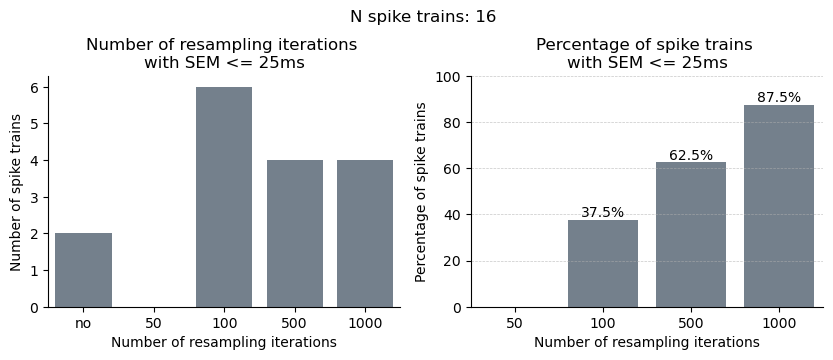

In [19]:
fig, axes = plt.subplots(1,2,figsize=(10,3))

sns.barplot(ax=axes[0], x='stabilization_point', y='signal', data=stab_point_count_df_sorted, color='slategray')
axes[0].set_title('Number of resampling iterations \nwith SEM <= 25ms')
axes[0].set_ylabel('Number of spike trains')

sns.barplot(ax=axes[1], x='m_iterations', y='n_signals_below_perc', data=stab_below_df, color='slategray')
labels = [str(np.round(v, 2)) + '%' if v else '' for v in axes[1].containers[0].datavalues]
axes[1].bar_label(axes[1].containers[0], labels=labels)
axes[1].set_title('Percentage of spike trains \nwith SEM <= 25ms')
axes[1].set_ylabel('Percentage of spike trains')
axes[1].set_ylim([0, 100])
axes[1].grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)

fig.suptitle(f'N spike trains: {len(stabilization_df)}', y=1.1)

for ax in axes.flat:
     ax.set_xlabel('Number of resampling iterations')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'stab_points.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'stab_points.svg' , bbox_inches='tight')